In [95]:
#Imports
import sys
sys.path.append('.')
sys.path.append('..')
import os
import pickle 
import pandas as pd
import numpy as np 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch


In [96]:
#config = predict_config.B_CNN
seed=42
evaluation_path = r"C:\Users\esthe\Documents\GitHub\classification_models\evaluations"
root_data = r"C:\Users\esthe\Documents\GitHub\classification_models\data\training"
root_predict = r"C:\Users\esthe\Documents\GitHub\classification_models\data\training\prediction"
prediction_file = "Esther_MA\hierarchical-B_CNN-classification-use_model_structure-20241106_222713-z8l98z7u42_epoch9.pt-V1_0-train-20241109_220923-42.csv"
features_load_name = r'Esther_MA\feature_maps\flatten-vgg16-classification-flatten-20241105_210302_epoch0.pt-V1_0'


In [97]:
#Load feature vecotrs
with open(os.path.join(root_predict, features_load_name), "rb") as f_in:
    stored_data = torch.load(f_in)
    #stored_data = pickle.load(f_in)
    stored_ids = stored_data['image_ids']
    stored_coarse_features = stored_data['coarse_features']
    stored_fine_features = stored_data['fine_features']
    stored_predictions = stored_data['prediction']


IndexError: too many indices for tensor of dimension 2

In [73]:
stored_df = pd.DataFrame({'image_id': stored_ids, 'coarse_features': str(stored_coarse_features),
                          'fine_features': str(stored_fine_features)})

In [74]:
all_encodings = []  # Initialize an empty DataFrame
index = 0
for id in stored_ids:
    coarse_feat = stored_coarse_features[index]
    fine_feat = stored_fine_features[index]
    
    data = {'image_id': int(id), 'fine_feat': str(fine_feat), 'coarse_feat': str(coarse_feat)}
    #row_df = pd.DataFrame(data, index=[index])  # Create a DataFrame from the dictionary
    all_encodings.append(data)  # Append the row DataFrame to the main DataFrame
    index += 1
    
stored_df = pd.DataFrame(all_encodings)    

    

In [75]:
#load the true labels
all_labels = pd.read_csv(os.path.join(root_data, f'V1_0\metadata\streetSurfaceVis_v1_0.csv'), usecols=['mapillary_image_id', 'surface_type', 'surface_quality'])
all_labels = all_labels[~all_labels['surface_quality'].isna()]
all_labels = all_labels[~all_labels['surface_type'].isna()]



In [76]:
#adding true labels to our stored_df

stored_df = pd.merge(stored_df, all_labels, how="left", left_on="image_id",
                     right_on="mapillary_image_id")


In [77]:
#separating our stored_df in valid and training data
all_predictions = pd.read_csv(os.path.join(root_predict, prediction_file))
all_predictions = all_predictions.rename(columns = {"Image":"image_id"})
all_predictions['image_id'] = all_predictions['image_id'].astype('int64')
valid_predictions = all_predictions[all_predictions['is_in_validation'] == 1]
train_predictions = all_predictions[all_predictions['is_in_validation'] == 0]

all_predictions

,image_id,Coarse_Prediction,Coarse_Probability,Fine_Prediction,Fine_Probability,is_in_validation,Seed
0,1000927687276860,concrete,0.955767,concrete__intermediate,0.788141,0.0,42
1,1001349260556407,unpaved,0.978377,unpaved__intermediate,0.672724,0.0,42
2,1001419624308587,asphalt,0.941767,asphalt__good,0.612522,1.0,42
3,1001712924422413,concrete,0.975066,concrete__excellent,0.910167,0.0,42
4,1001853784055707,asphalt,0.956890,asphalt__excellent,0.752695,0.0,42
...,...,...,...,...,...,...,...
8341,997256148134538,asphalt,0.541623,asphalt__excellent,0.727747,0.0,42
8342,998443217521030,unpaved,0.993184,unpaved__intermediate,0.574507,0.0,42
8343,999340993934138,paving_stones,0.999927,paving_stones__excellent,0.924990,1.0,42
8344,999425643924630,concrete,0.622896,concrete__good,0.476893,0.0,42


In [78]:
# merge all_predictions with stored_df
valid_df = pd.merge(stored_df, all_predictions[all_predictions['is_in_validation'] == 1],
                     how='inner', on='image_id')

train_df = pd.merge(stored_df, all_predictions[all_predictions['is_in_validation'] == 0],
                     how='inner', on='image_id')

In [79]:
id_position = {image_id: position for position, image_id in enumerate(stored_ids)}
valid_df['image_id'] = valid_df['image_id'].astype('str')
valid_df['position'] = valid_df['image_id'].map(id_position)
train_df['image_id'] = train_df['image_id'].astype('str')
train_df['position'] = train_df['image_id'].map(id_position)
train_df


,image_id,fine_feat,coarse_feat,mapillary_image_id,surface_type,surface_quality,Coarse_Prediction,Coarse_Probability,Fine_Prediction,Fine_Probability,is_in_validation,Seed,position
0,1132150697721186,"tensor([0.0066, 0.0083, 0.0084, ..., 0.0233, ...","tensor([0.0152, 0.0072, 0.0086, ..., 0.0250, ...",1132150697721186,asphalt,bad,asphalt,0.965833,asphalt__intermediate,0.370161,0.0,42,1
1,1156688858072710,"tensor([0.0078, 0.0083, 0.0091, ..., 0.0232, ...","tensor([0.0151, 0.0090, 0.0114, ..., 0.0239, ...",1156688858072710,asphalt,bad,asphalt,0.953029,asphalt__bad,0.784173,0.0,42,2
2,1165154770939283,"tensor([0.0067, 0.0084, 0.0085, ..., 0.0214, ...","tensor([0.0179, 0.0138, 0.0128, ..., 0.0199, ...",1165154770939283,asphalt,bad,asphalt,0.746602,asphalt__bad,0.994017,0.0,42,3
3,1175113039579141,"tensor([0.0071, 0.0082, 0.0085, ..., 0.0223, ...","tensor([0.0177, 0.0129, 0.0137, ..., 0.0203, ...",1175113039579141,asphalt,bad,sett,0.820689,sett__intermediate,0.116793,0.0,42,4
4,1178313585927604,"tensor([0.0075, 0.0090, 0.0094, ..., 0.0232, ...","tensor([0.0221, 0.0206, 0.0200, ..., 0.0223, ...",1178313585927604,asphalt,bad,asphalt,0.599907,asphalt__bad,0.277412,0.0,42,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,582003383203689,"tensor([0.0074, 0.0090, 0.0090, ..., 0.0220, ...","tensor([0.0196, 0.0176, 0.0156, ..., 0.0273, ...",582003383203689,asphalt,bad,asphalt,0.919638,asphalt__intermediate,0.773982,0.0,42,88
70,586714606473278,"tensor([0.0072, 0.0090, 0.0090, ..., 0.0227, ...","tensor([0.0211, 0.0191, 0.0191, ..., 0.0193, ...",586714606473278,asphalt,bad,asphalt,0.732436,asphalt__intermediate,0.519736,0.0,42,89
71,635878951880307,"tensor([0.0078, 0.0096, 0.0094, ..., 0.0226, ...","tensor([0.0210, 0.0198, 0.0199, ..., 0.0286, ...",635878951880307,asphalt,bad,asphalt,0.823155,concrete__intermediate,0.568715,0.0,42,92
72,669770768319743,"tensor([0.0077, 0.0092, 0.0092, ..., 0.0234, ...","tensor([0.0199, 0.0185, 0.0188, ..., 0.0257, ...",669770768319743,asphalt,bad,asphalt,0.913199,asphalt__bad,0.678041,0.0,42,93


In [82]:
validation_input_coarse_tsne = stored_coarse_features[valid_df['position'].to_list()]
validation_labels_coarse_tsne = valid_df['surface_type'].to_list()

train_input_coarse_tsne = stored_coarse_features[train_df['position'].to_list()]
train_labels_coarse_tsne = train_df['surface_type'].to_list()

validation_input_fine_tsne = stored_fine_features[valid_df['position'].to_list()]
validation_labels_fine_tsne = valid_df['surface_type'].to_list()

train_input_fine_tsne = stored_fine_features[train_df['position'].to_list()]
train_labels_fine_tsne = train_df['surface_type'].to_list()

validation_input_coarse_tsne


tensor([[0.0205, 0.0179, 0.0179,  ..., 0.0262, 0.0259, 0.0269],
        [0.0176, 0.0104, 0.0103,  ..., 0.0290, 0.0292, 0.0281],
        [0.0199, 0.0165, 0.0143,  ..., 0.0202, 0.0190, 0.0224],
        ...,
        [0.0223, 0.0185, 0.0174,  ..., 0.0282, 0.0279, 0.0271],
        [0.0213, 0.0198, 0.0185,  ..., 0.0264, 0.0271, 0.0270],
        [0.0160, 0.0093, 0.0096,  ..., 0.0235, 0.0209, 0.0209]])

In [83]:


tsne_coarse_valid = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=15, random_state=seed).fit_transform(validation_input_coarse_tsne)
tsne_coarse_train = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5, random_state=seed).fit_transform(train_input_coarse_tsne)

tsne_fine_valid = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=15, random_state=seed).fit_transform(validation_input_fine_tsne)
tsne_fine_train = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5, random_state=seed).fit_transform(train_input_fine_tsne)


In [84]:
from sklearn.preprocessing import LabelEncoder

def create_plot(tsne_data, tsne_label, flag):
    label_encoder = LabelEncoder()
    scatter_labels_encoded = label_encoder.fit_transform(tsne_label)

    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=scatter_labels_encoded, cmap='viridis', s=10)
    plt.colorbar(scatter, ticks=range(len(label_encoder.classes_)), label='Surface Type').set_ticklabels(label_encoder.classes_)
    plt.title('t-SNE coarse features')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.savefig(os.path.join(evaluation_path, f'{flag}_tsne_plot_validation.jpeg'))

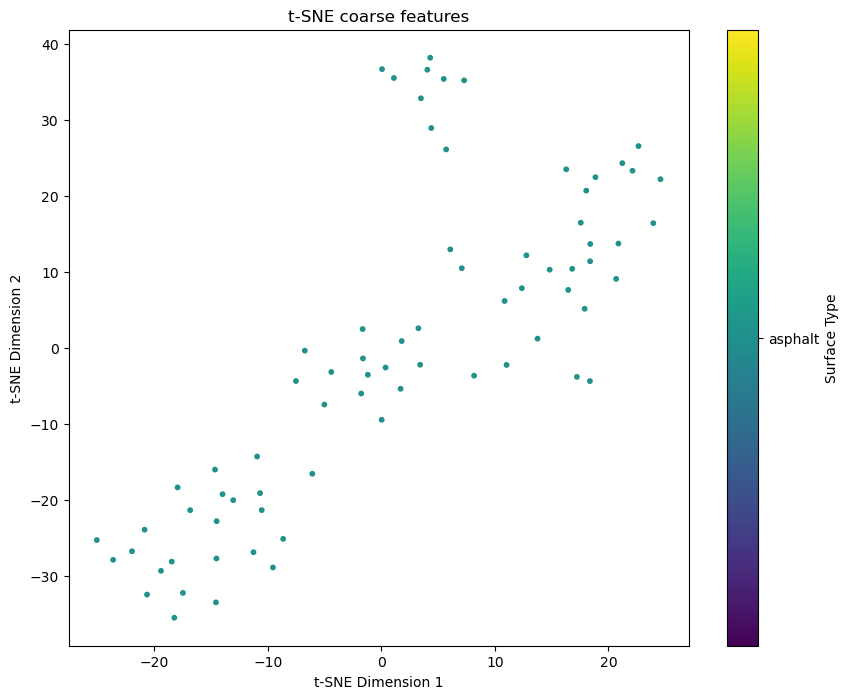

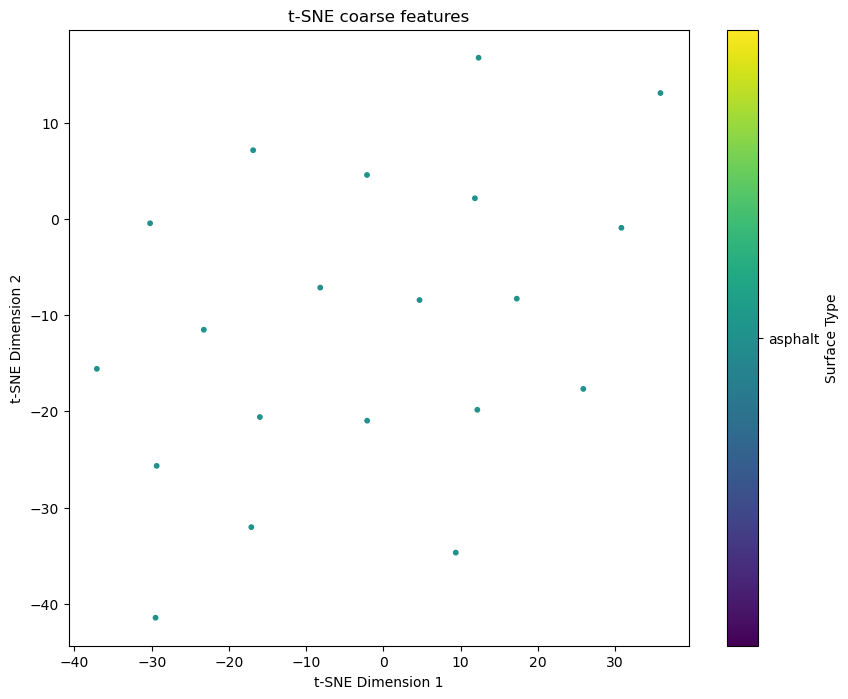

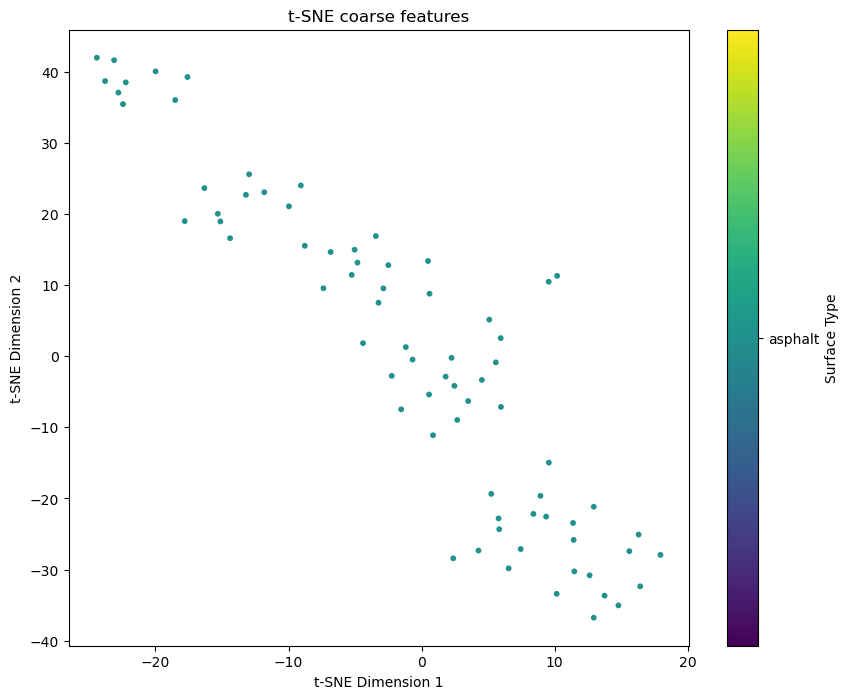

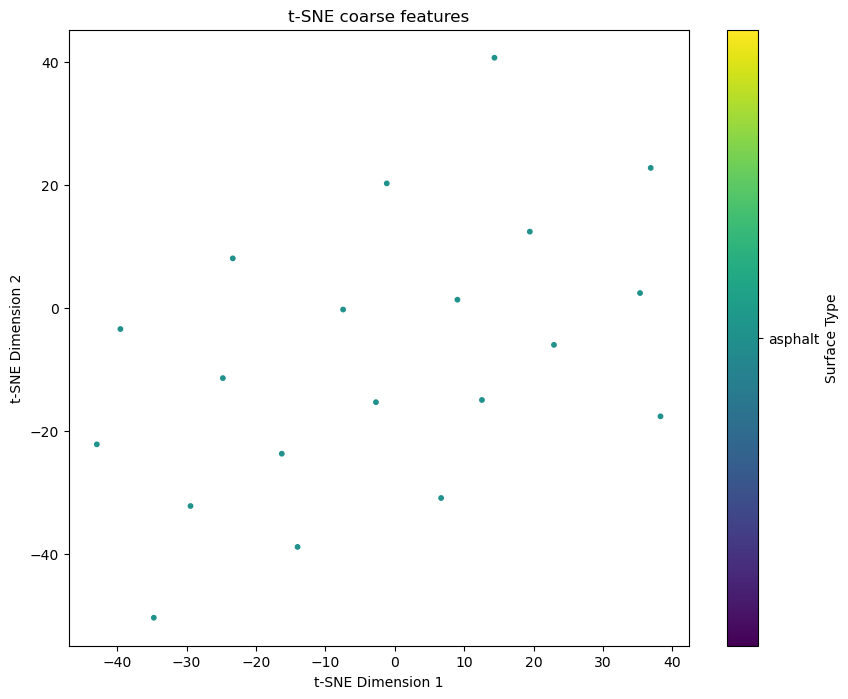

In [85]:
create_plot(tsne_coarse_train, train_labels_coarse_tsne, 'train_coarse')
create_plot(tsne_coarse_valid, validation_labels_coarse_tsne, 'valid_coarse')

create_plot(tsne_fine_train, train_labels_fine_tsne, 'train_fine')
create_plot(tsne_fine_valid, validation_labels_fine_tsne, 'valid_fine')


